In [88]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1" 
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import sys

from src.run_gsort_v2_wuericmod import *
import argparse
from scipy.io import loadmat
from itertools import product
import tqdm
import logging
import re
import src.utilities.electrode_map as emap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [277]:
ANALYSIS_BASE = '/Volumes/Analysis'
# dataset = '2016-06-13-0'
dataset = '2019-06-20-0'
# vstim_datarun = 'kilosort_data000/data000'
vstim_datarun = "kilosort_data000/data000"
# estim_datarun = 'data001'
estim_datarun = "data001"
vstim_analysis_path = os.path.join(ANALYSIS_BASE, dataset, vstim_datarun)

print(vstim_analysis_path)
estim_analysis_path = os.path.join(ANALYSIS_BASE, dataset, estim_datarun)
pattern_path = os.path.join(estim_analysis_path, 'pattern_files')

vstim_data = vl.load_vision_data(vstim_analysis_path,
                                 vstim_datarun.rsplit('/')[-1],
                                 include_params=True,
                                 include_ei=True,
                                 include_noise=True,
                                 include_neurons=True)
noise = vstim_data.channel_noise
duplicates, cell_ei = compute_duplicates(vstim_data, noise)
# duplicates = []

/Volumes/Analysis/2019-06-20-0/kilosort_data000/data000


In [278]:
mutual_threshold = 1
compartments = ['soma', 'mixed']

excluded_types = ['bad', 'dup']
all_cell_types = [ct for ct in vstim_data.get_all_present_cell_types() if 'bad' not in ct and 'dup' not in ct]
cell_types= ['parasol', 'midget']
start_time_limit = 0
end_time_limit = 30
pt = 1.5
time_limit = 30

In [279]:
total_electrode_list, total_cell_to_electrode_list, mutual_cells, array_id = get_cell_info(all_cell_types, vstim_data, compartments, noise, mutual_threshold=mutual_threshold)
            

In [422]:
cell = 309
k = 32
p = 433

In [423]:
electrode_list =  list(set([e for c in mutual_cells[cell] for e in total_cell_to_electrode_list[c]]))
cell_to_electrode_list = {k:v for k,v in total_cell_to_electrode_list.items() if k in mutual_cells[cell]}

try:
    signal = get_oldlabview_pp_data(estim_analysis_path , p, k)
except:
    print("Signal doesn't exists")

num_trials = len(signal)
raw_signal = signal[:, electrode_list, start_time_limit:end_time_limit].astype(float) 
mask =  get_mask(raw_signal, )
cluster_cliques = cluster_each_cell(raw_signal,mask, cell_to_electrode_list, electrode_list, noise, "", cluster_delay = 0)
event_labels = convert_cliques_to_labels(cluster_cliques, num_trials)

significant_electrodes = np.arange(len(electrode_list))
print("event_labels",event_labels)
event_labels = first_merge_event_cliques_by_noise(electrode_list, raw_signal, event_labels,  mask, significant_electrodes, noise)
print("event_labels",event_labels)

data_on_cells = get_center_eis(cell, electrode_list, ap = (vstim_analysis_path[:-7], vstim_datarun.rsplit('/')[-1]), excluded_types = excluded_types, excluded_cells = list(duplicates), power_threshold=pt, array_id = array_id, sample_len_left = time_limit+20 ,sample_len_right = time_limit+20)
            
finished, G, (_, _), (event_labels_with_virtual, _), (event_labels, final_signals), edge_to_matched_signals, A, mask, note = gsort_spike_sorting(event_labels, significant_electrodes, electrode_list, raw_signal, mask, 1, 1000, noise, data_on_cells, artifact_cluster_estimate=None, raw=True )



total_p, cell_in_clusters = get_probabilities(G, event_labels_with_virtual)


event_labels [0 0 0 3 3 2 0 3 3 3 0 0 3 3 0 2 1 3 4 0 3 3 0 2 3]
event_labels [0 0 0 3 3 2 0 3 3 3 0 0 3 3 0 2 1 3 4 0 3 3 0 2 3]


In [424]:
bad_edges = []
bad_edges = compute_cosine_error(mask, G, edge_to_matched_signals, event_labels_with_virtual, cell, bad_edges)
print(bad_edges)
peak_electrode = np.argmax(np.max(np.abs(data_on_cells[1][data_on_cells[0].index(cell)]), axis = 1))
bad_edges = compute_latency_error(mask, G, edge_to_matched_signals, event_labels_with_virtual, cell, bad_edges,peak_electrode,  too_early = 5, too_late = time_limit -5,offset = data_on_cells[-1][0,0])
print(bad_edges)
bad_edges = compute_small_signal_error(mask, G, edge_to_matched_signals, event_labels_with_virtual, cell, bad_edges,peak_electrode,  too_small = 1)
print(bad_edges)
p_error = compute_error(G, event_labels_with_virtual, cell, bad_edges)
total_p[cell]-p_error

[]
[]
[]


0.96

{(0, 3): Text(0.0, -0.3333333333333333, '310'),
 (3, 2): Text(0.5, -0.16666666666666666, '316'),
 (3, 1): Text(0.6666666666666666, 0.0, '316'),
 (4, 0): Text(-0.6666666666666666, 0.0, '309')}

<Figure size 432x288 with 0 Axes>

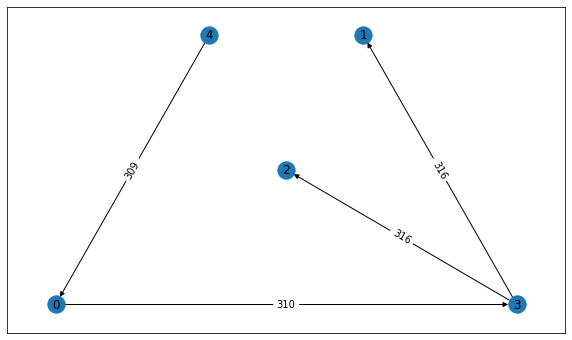

In [425]:
plt.figure()
fig, ax = plt.subplots(1,1,figsize = (10,6))
pos = nx.planar_layout(G)
nx.draw_networkx(G,pos, ax = ax)

edge_labels = nx.get_edge_attributes(G,'cell')
nx.draw_networkx_edge_labels(G, pos,  edge_labels)

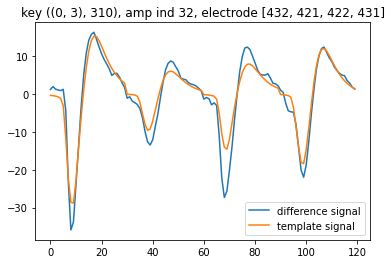

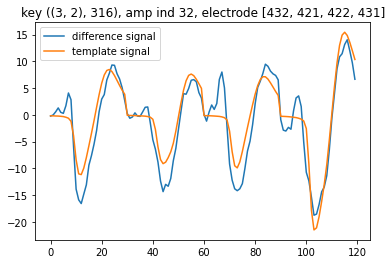

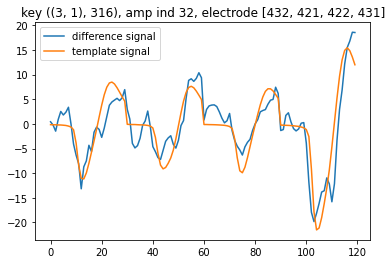

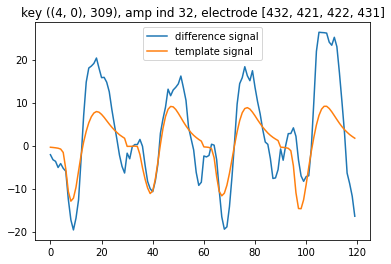

In [426]:
for key in list(edge_to_matched_signals.keys()):
    plt.figure()
    ax = plt.subplot(111)
    ax.plot( edge_to_matched_signals[key][0].flatten(), label ='difference signal')
    ax.plot( edge_to_matched_signals[key][1].flatten(), label ='template signal')

    ax.set_title("key %s, amp ind %s, electrode %s"%(key, k, electrode_list))
    ax.legend()

In [23]:
bad_edges = []
bad_edges = compute_cosine_error(mask, G, edge_to_matched_signals, event_labels_with_virtual, cell, bad_edges)
peak_electrode = np.argmax(np.max(np.abs(data_on_cells[1][data_on_cells[0].index(cell)]), axis = 1))
bad_edges = compute_latency_error(mask, G, edge_to_matched_signals, event_labels_with_virtual, cell, bad_edges,peak_electrode,  too_early = 5)
p_error = compute_error(G, event_labels_with_virtual, cell, bad_edges)

Text(0.5, 1.0, 'signal traces at 36, electrode 481')

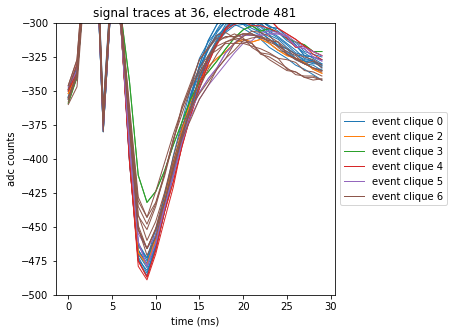

In [417]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))
#ax.settitle("p %s e %s k %s" %(p, e, k))
j =1

for i,l in enumerate(list(set(event_labels_with_virtual))):
    
    ax.plot(raw_signal[event_labels_with_virtual == l, :].reshape((-1, len(electrode_list)*time_limit))[0, j*time_limit:(j+1)*time_limit].T,linewidth=1, color = "C"+str(i%10), label = "event clique " + str(l));
    
    ax.plot(raw_signal[event_labels_with_virtual == l, :].reshape((-1, len(electrode_list)*time_limit))[:, j*time_limit:(j+1)*time_limit].T,linewidth=1, color = "C"+str(i%10));

    ax.set_xlabel("time (ms)")
    ax.set_ylabel("adc counts")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim([-500, -300])
# A = 
ax.set_title("signal traces at %s, electrode %s" %(k, electrode_list[j]))

In [362]:
A = np.median(signal[event_labels_with_virtual == 2, :, :time_limit], axis = 0)
B = np.median(signal[event_labels_with_virtual != 2, :, :time_limit], axis = 0)
C = np.min(A-B, axis = 1)
C[np.abs(C) <= noise*2] = 0

In [363]:
D = np.abs(np.min(vstim_data.get_ei_for_cell(cell).ei, axis = 1))
D[np.abs(D) <= noise*2] = 0

(-396.0, 396.0, -429.0, 429.0)

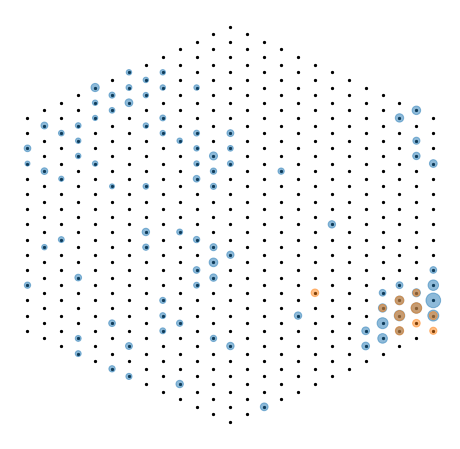

In [364]:
# %matplotlib notebook
# Constants.
NUM_SIGMAS = 2 # Kind of low, but at least it's noise-based.
SIZE_SCALAR = 5 

fig,ax = plt.subplots(1,1,figsize=(8,8))


# Get the electrode map to plot on the array.
e_map = emap.LITKE_519_ARRAY_MAP
xcoords = e_map[:,0]
ycoords = e_map[:,1]
num_channels = e_map.shape[0]

ax.scatter(xcoords,ycoords,
           c='k',s=5)

ax.scatter(xcoords,ycoords,
           c='C0',s=np.abs(C)*5, alpha = 0.5)

ax.scatter(xcoords,ycoords,
           c='C1',s=D*5, alpha = 0.5)

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')


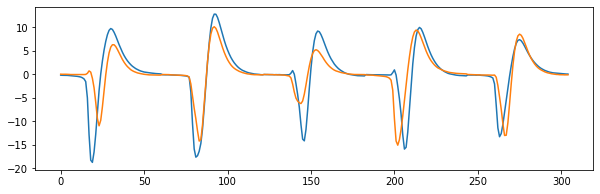

In [322]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(vstim_data.get_ei_for_cell(95).ei[electrode_list].flatten())
ax.plot(vstim_data.get_ei_for_cell(99).ei[electrode_list].flatten())


In [321]:
vstim_data.get_cell_ids()

[111,
 332,
 2,
 112,
 333,
 3,
 220,
 113,
 4,
 335,
 116,
 5,
 117,
 337,
 221,
 118,
 338,
 120,
 6,
 121,
 222,
 9,
 122,
 341,
 123,
 12,
 125,
 223,
 126,
 13,
 342,
 224,
 14,
 343,
 127,
 345,
 128,
 16,
 226,
 346,
 129,
 17,
 347,
 228,
 229,
 18,
 348,
 19,
 130,
 131,
 132,
 21,
 230,
 133,
 22,
 349,
 135,
 233,
 350,
 138,
 234,
 139,
 351,
 140,
 24,
 235,
 142,
 352,
 25,
 236,
 26,
 143,
 353,
 237,
 354,
 145,
 27,
 356,
 146,
 28,
 357,
 147,
 29,
 148,
 358,
 30,
 149,
 359,
 150,
 238,
 31,
 151,
 360,
 239,
 33,
 152,
 240,
 362,
 35,
 241,
 363,
 37,
 154,
 364,
 155,
 365,
 38,
 156,
 366,
 244,
 39,
 157,
 42,
 245,
 158,
 43,
 367,
 246,
 44,
 368,
 247,
 161,
 249,
 250,
 45,
 369,
 370,
 252,
 162,
 46,
 371,
 163,
 254,
 47,
 372,
 255,
 50,
 373,
 256,
 51,
 165,
 257,
 167,
 258,
 53,
 374,
 168,
 55,
 169,
 375,
 171,
 172,
 376,
 56,
 173,
 377,
 378,
 259,
 174,
 57,
 379,
 175,
 260,
 58,
 380,
 176,
 59,
 261,
 381,
 263,
 382,
 264,
 177,
 383,
 266